In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [133]:
df_power= pd.read_csv('C:/Users/admin/Desktop/스프린트1/최종광주_시군구_업종별_전력사용량.csv',encoding='cp949',index_col=[0])
df_people = pd.read_csv('C:/Users/admin/Desktop/스프린트1/광주광역시_자치구별 인구밀도 현황_20220331.csv',encoding='cp949')

In [134]:
df_people=df_people[['시군구','인구(명)','인구밀도(km^2)']]

In [135]:
df_people

,시군구,인구(명),인구밀도(km^2)
0,동구,103470,2098.357331
1,서구,291231,6097.801508
2,남구,215575,3534.595835
3,북구,427114,3551.292924
4,광산구,404221,1814.358813


In [136]:
df_power.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 956 entries, 0 to 955
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   년도             956 non-null    int64  
 1   지역             956 non-null    object 
 2   시군구            956 non-null    object 
 3   계약구분           956 non-null    object 
 4   고객수            956 non-null    object 
 5   사용량(kWh)       956 non-null    object 
 6   전기요금(원)        956 non-null    object 
 7   평균판매단가(원/kWh)  956 non-null    float64
dtypes: float64(1), int64(1), object(6)
memory usage: 67.2+ KB


In [137]:
df_power['년도'] = df_power['년도'].astype(str)
df_power['년도'] = df_power['년도'].apply(lambda x: pd.to_datetime(str(x),format='%Y%m'))
df_power['year'] = df_power['년도'].dt.year
df_power['month'] = df_power['년도'].dt.month
df_power.reset_index(drop=True,inplace=True)

In [138]:
df_power.head()

,년도,지역,시군구,계약구분,고객수,사용량(kWh),전기요금(원),평균판매단가(원/kWh),year,month
0,2021-01-01,광주광역시,광산구,가로등,"12,803","2,629,917","281,124,107",106.9,2021,1
1,2021-01-01,광주광역시,동구,주택용,"42,234","15,703,732","1,835,417,998",116.9,2021,1
2,2021-01-01,광주광역시,동구,합계,"61,110","60,019,593","7,274,669,793",121.2,2021,1
3,2021-01-01,광주광역시,북구,가로등,"12,366","1,917,620","194,213,863",101.3,2021,1
4,2021-01-01,광주광역시,북구,교육용,193,"15,035,409","1,431,892,142",95.2,2021,1


In [139]:
df_power['사용량(kWh)']=df_power['사용량(kWh)'].str.replace(',','').str.strip().astype('int64')
df_power['고객수']=df_power['고객수'].str.replace(',','').str.strip().astype('int64')

In [140]:
gu_total = df_power[df_power['계약구분']=='합계']

In [141]:
gwangju=gu_total.groupby('시군구')['사용량(kWh)','고객수'].sum()
gwangju=gwangju.reset_index()
gwangju['사용량/고객수']=gwangju['사용량(kWh)']/gwangju['고객수']
gwangju

,시군구,사용량(kWh),고객수,사용량/고객수
0,광산구,7282620910,3262260,2232.385190
1,남구,1524981832,1961470,777.468853
2,동구,1283418916,1469388,873.437728
3,북구,4746165591,4131324,1148.824346
4,서구,2735228456,2162880,1264.623306


In [142]:
gu_total11 = gwangju.merge(df_people,on='시군구',how='outer')

In [143]:
gu_total11.columns

Index(['시군구', '사용량(kWh)', '고객수', '사용량/고객수', '인구(명)', '인구밀도(km^2)'], dtype='object')

In [199]:
corr_matrix = gu_total11.corr()
corr_matrix

,사용량(kWh),고객수,사용량/고객수,인구(명),인구밀도(km^2)
사용량(kWh),1.000000,0.784801,0.918839,0.861066,-0.307960
고객수,0.784801,1.000000,0.486899,0.937096,-0.083466
사용량/고객수,0.918839,0.486899,1.000000,0.655454,-0.281897
인구(명),0.861066,0.937096,0.655454,1.000000,0.083213
인구밀도(km^2),-0.307960,-0.083466,-0.281897,0.083213,1.000000


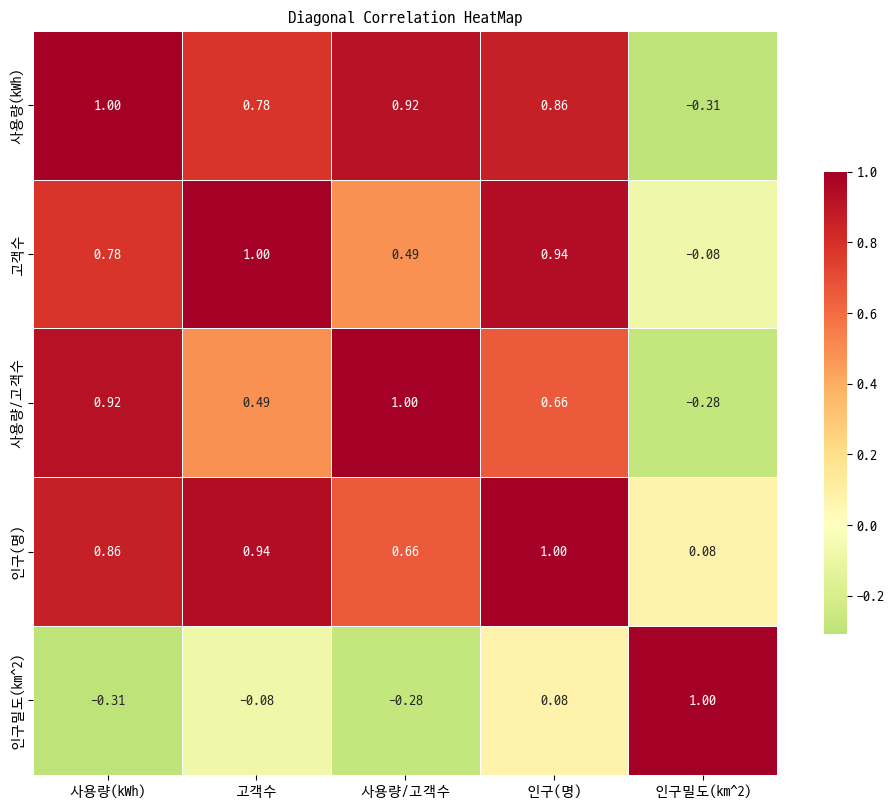

In [200]:
f, ax = plt.subplots(figsize=(12, 12))
corr = gu_total11.select_dtypes(exclude=["object","bool"]).corr()

# 대각 행렬을 기준으로 한 쪽만 나타나게 설정해줍니다.
mask = np.zeros_like(corr_matrix, dtype='bool')
mask[np.triu_indices_from(mask)] = False

g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax= 1, mask=mask, 
center=0, annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Diagonal Correlation HeatMap")
plt.show()

In [146]:
import folium,json

In [147]:
# jsonfile = open('C:/Users/admin/Desktop/전력빅데이터/HangJeongDong_ver20230101.geojson','r',encoding='utf-8').read()
jsonfile = open('C:/Users/admin/Desktop/전력빅데이터/TL_SCCO_SIG.json','r',encoding='utf-8').read()
jsondata = json.loads(jsonfile)

jsondata_gwangju = {'type': 'FeatureCollection'}
jsondata_pick = []
jsondata_gu = []
for idx in jsondata['features']:
    # 법정동코드 광산구 29200 남구 29155 동구 29110 북구 29170  서구 29140
    if (idx['properties']['SIG_CD'] == '29200')|(idx['properties']['SIG_CD'] == '29155')|(idx['properties']['SIG_CD'] == '29110')|(idx['properties']['SIG_CD'] == '29170')|(idx['properties']['SIG_CD'] == '29140'):
        print(idx)
        dong = idx['properties']['SIG_KOR_NM'].split()[-1].strip()
        print(dong)
        jsondata_gu.append(dong)
        idx['id'] = dong
        jsondata_pick.append(idx)
jsondata_gwangju['features'] = jsondata_pick

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[127.00431802111373, 35.12129063722381], [126.98895069186915, 35.09498758315934], [126.93599500175853, 35.07448169707949], [126.91922340853777, 35.09153166163333], [126.92886536255442, 35.125928989325935], [126.90974273852488, 35.14918948831353], [126.90715348906502, 35.15144018877212], [126.95522913082353, 35.152209988863795], [127.00431802111373, 35.12129063722381]]]}, 'properties': {'SIG_CD': '29110', 'SIG_ENG_NM': 'Dong-gu', 'SIG_KOR_NM': '동구'}}
동구
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[126.90715348906502, 35.15144018877212], [126.90974273852488, 35.14918948831353], [126.88862546053038, 35.1215898570284], [126.81985704612588, 35.09107543698663], [126.80252481602118, 35.09347727464407], [126.82932300479948, 35.140598940256076], [126.83874984951383, 35.17843442954697], [126.88193309184308, 35.170518744996606], [126.90715348906502, 35.15144018877212]]]}, 'properties': {'SIG_CD': '29140'

In [148]:
map = folium.Map((35.2147680757968,126.68902856451213),zoom_start=10)

folium.Choropleth(geo_data = jsondata_gwangju,
                  data = gwangju,
                  columns=['시군구','사용량/고객수'],
                  key_on='feature.id',
                  legend_name='광주 전력사용량',
                  bins=10,fill_color='OrRd').add_to(map)
map

In [149]:
e_df = pd.read_excel('C:/Users/admin/Desktop/스프린트1/광주광역시 전력사용량 2018_2022.xlsx',index_col=[0])

In [150]:
e_df

,연도,시도,시군구,계약종별,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,2018,광주광역시,동구,주택용,12565515,12783761,11012887,11236282,10513158,10846953,12022027,16939199,13120624,10542157,11193546,11773438
1,2018,광주광역시,동구,일반용,37254635,37492338,30025222,27929138,26990130,30164222,34920611,41800347,34602084,26785376,26979182,31170303
2,2018,광주광역시,동구,교육용,4175925,3986127,3313703,3200049,2563051,3067871,3454391,4011879,3752876,2792710,2977627,3611654
3,2018,광주광역시,동구,산업용,2931267,2845500,2406107,2324816,2217184,2431929,2574932,3032969,2532668,2253940,2357143,2685891
4,2018,광주광역시,동구,농사용,105784,111899,91912,82281,71951,72193,75790,109550,126947,91868,121223,97694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2022,광주광역시,남구,산업용,3845966,3667295,3540659,3662662,3510075,3617016,3902396,4011986,3822018,3487924,3816608,4131545
196,2022,광주광역시,남구,농사용,1291574,1218056,1016295,776865,681624,832092,737684,855388,785521,639628,1371182,871011
197,2022,광주광역시,남구,가로등,1162161,1072994,987559,976265,922682,878706,869580,909639,961242,1021102,1054782,1095604
198,2022,광주광역시,남구,심 야,2287030,2280806,1858417,1018792,436186,298735,236946,218773,231524,357315,932477,1752990


In [151]:
e_ind_df = e_df[e_df['계약종별']=='산업용']
e_farm_df=e_df[e_df['계약종별']=='농사용']
e_edu_df = e_df[e_df['계약종별']=='교육용']
e_house_df = e_df[e_df['계약종별']=='주택용']

In [152]:
e_ind_df = e_ind_df.melt(id_vars=['연도','시도','시군구','계약종별'],
                var_name='월별',
                value_name='전력사용량')
e_farm_df= e_farm_df.melt(id_vars=['연도','시도','시군구','계약종별'],
                var_name='월별',
                value_name='전력사용량')
e_house_df = e_house_df.melt(id_vars=['연도','시도','시군구','계약종별'],
                var_name='월별',
                value_name='전력사용량')
e_edu_df = e_edu_df.melt(id_vars=['연도','시도','시군구','계약종별'],
                        var_name='월별',
                        value_name='전력사용량')

e_house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   연도      300 non-null    int64 
 1   시도      300 non-null    object
 2   시군구     300 non-null    object
 3   계약종별    300 non-null    object
 4   월별      300 non-null    object
 5   전력사용량   300 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 14.2+ KB


In [153]:
e_edu_df

,연도,시도,시군구,계약종별,월별,전력사용량
0,2018,광주광역시,동구,교육용,1월,4175925
1,2018,광주광역시,서구,교육용,1월,2568928
2,2018,광주광역시,북구,교육용,1월,14609186
3,2018,광주광역시,광산구,교육용,1월,6829289
4,2018,광주광역시,남구,교육용,1월,3626487
...,...,...,...,...,...,...
295,2022,광주광역시,동구,교육용,12월,3536312
296,2022,광주광역시,서구,교육용,12월,2340582
297,2022,광주광역시,북구,교육용,12월,15457204
298,2022,광주광역시,광산구,교육용,12월,6157714


In [154]:
#산업용
ind_east = e_ind_df[e_ind_df['시군구']=='동구']
ind_west = e_ind_df[e_ind_df['시군구']=='서구']
ind_south = e_ind_df[e_ind_df['시군구']=='남구']
ind_north = e_ind_df[e_ind_df['시군구']=='북구']
ind_gwang = e_ind_df[e_ind_df['시군구']=='광산구']

#교육용
edu_east = e_edu_df[e_edu_df['시군구']=='동구']
edu_west = e_edu_df[e_edu_df['시군구']=='서구']
edu_south = e_edu_df[e_edu_df['시군구']=='남구']
edu_north = e_edu_df[e_edu_df['시군구']=='북구']
edu_gwang = e_edu_df[e_edu_df['시군구']=='광산구']

#농업용
farm_east = e_farm_df[e_farm_df['시군구']=='동구']
farm_west = e_farm_df[e_farm_df['시군구']=='서구']
farm_south = e_farm_df[e_farm_df['시군구']=='남구']
farm_north = e_farm_df[e_farm_df['시군구']=='북구']
farm_gwang = e_farm_df[e_farm_df['시군구']=='광산구']


#주택용
h_east = e_house_df[e_house_df['시군구']=='동구']
h_west = e_house_df[e_house_df['시군구']=='서구']
h_south = e_house_df[e_house_df['시군구']=='남구']
h_north = e_house_df[e_house_df['시군구']=='북구']
h_gwang = e_house_df[e_house_df['시군구']=='광산구']

In [155]:
month_order = ['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']

h_east['월별'] = pd.Categorical(h_east['월별'], categories=month_order, ordered=True)
h_west['월별'] = pd.Categorical(h_west['월별'], categories=month_order, ordered=True)
h_south['월별'] = pd.Categorical(h_south['월별'], categories=month_order, ordered=True)
h_north['월별'] = pd.Categorical(h_north['월별'], categories=month_order, ordered=True)


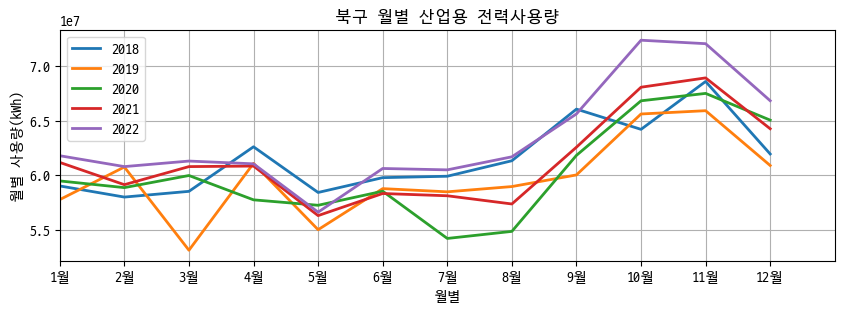

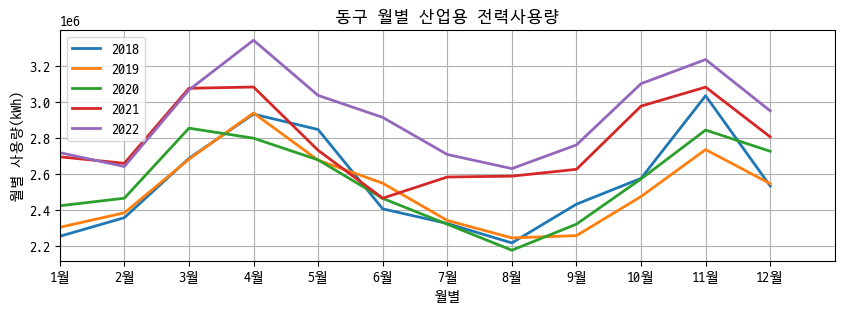

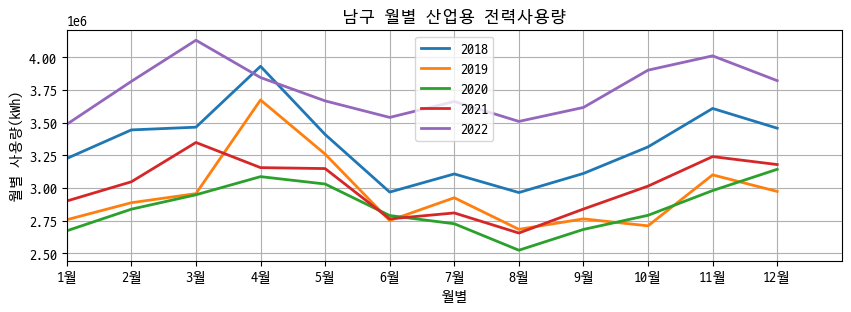

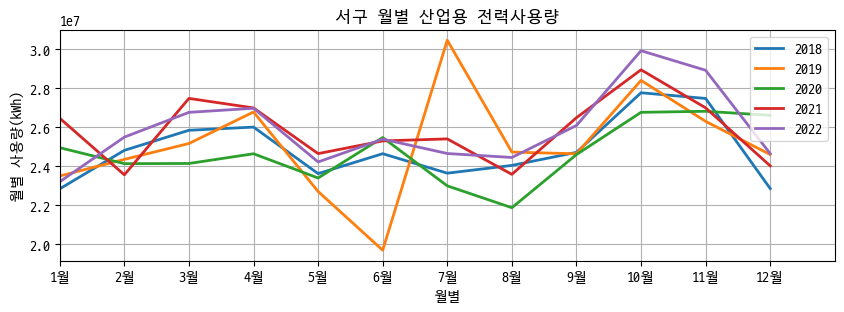

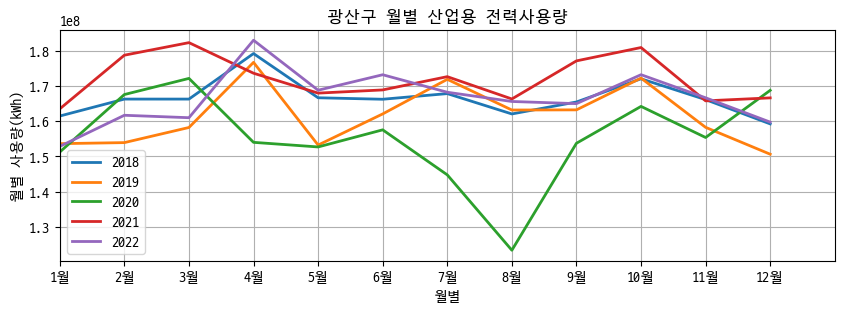

In [156]:
# 산업용
ind_north_df = ind_north.pivot_table(index='월별',columns='연도',values='전력사용량')

title = '북구 월별 산업용 전력사용량'
ylabel = '월별 사용량(kWh)'
xlabel = '월별'

fig, ax = plt.subplots(figsize=(10, 3))
ind_north_df.plot(ax=ax, lw=2, label='North')

ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_xlim(left=1, right=12)  # set x-axis limit to display only first 12 months
ax.set_xticks(range(0, 12))  # set ticks for 12 months
ax.set_xticklabels(['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])
ax.legend(loc=0)
plt.grid()

ind_east_df = ind_east.pivot_table(index='월별',columns='연도',values='전력사용량')

title = '동구 월별 산업용 전력사용량'
ylabel = '월별 사용량(kWh)'
xlabel = '월별'

fig, ax = plt.subplots(figsize=(10, 3))
ind_east_df.plot(ax=ax, lw=2, label='East')

ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_xlim(left=1, right=12)  # set x-axis limit to display only first 12 months
ax.set_xticks(range(0, 12))  # set ticks for 12 months
ax.set_xticklabels(['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])
ax.legend(loc=0)
plt.grid()


ind_south_df = ind_south.pivot_table(index='월별',columns='연도',values='전력사용량')

title = '남구 월별 산업용 전력사용량'
ylabel = '월별 사용량(kWh)'
xlabel = '월별'

fig, ax = plt.subplots(figsize=(10, 3))
ind_south_df.plot(ax=ax, lw=2, label='South')

ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_xlim(left=1, right=12)  # set x-axis limit to display only first 12 months
ax.set_xticks(range(0, 12))  # set ticks for 12 months
ax.set_xticklabels(['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])
ax.legend(loc=0)
plt.grid()

ind_west_df = ind_west.pivot_table(index='월별',columns='연도',values='전력사용량')

title = '서구 월별 산업용 전력사용량'
ylabel = '월별 사용량(kWh)'
xlabel = '월별'

fig, ax = plt.subplots(figsize=(10, 3))
ind_west_df.plot(ax=ax, lw=2, label='West')

ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_xlim(left=1, right=12)  # set x-axis limit to display only first 12 months
ax.set_xticks(range(0, 12))  # set ticks for 12 months
ax.set_xticklabels(['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])
ax.legend(loc=0)
plt.grid()


ind_gwang_df = ind_gwang.pivot_table(index='월별',columns='연도',values='전력사용량')

title = '광산구 월별 산업용 전력사용량'
ylabel = '월별 사용량(kWh)'
xlabel = '월별'

fig, ax = plt.subplots(figsize=(10, 3))
ind_gwang_df.plot(ax=ax, lw=2, label='West')

ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_xlim(left=1, right=12)  # set x-axis limit to display only first 12 months
ax.set_xticks(range(0, 12))  # set ticks for 12 months
ax.set_xticklabels(['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])
ax.legend(loc=0)
plt.grid()

plt.show()

<Figure size 1500x500 with 0 Axes>

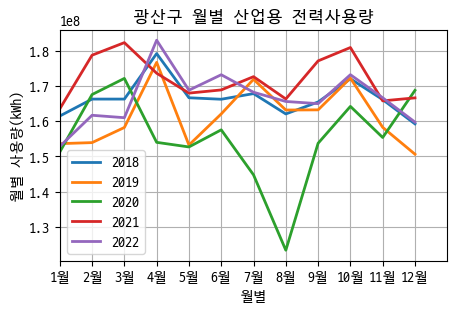

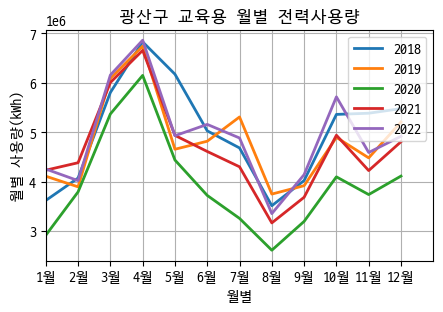

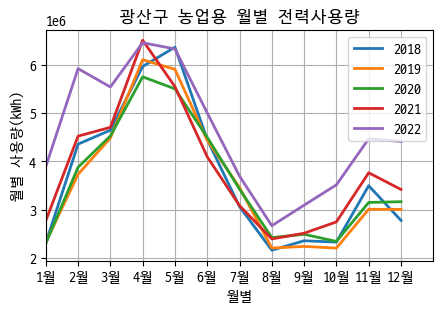

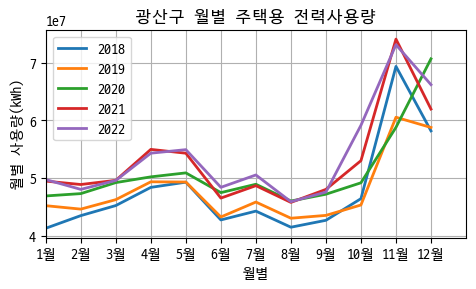

In [157]:
plt.figure(figsize=(15,5))
# 산업용
ind_gwang_df = ind_gwang.pivot_table(index='월별',columns='연도',values='전력사용량')

title = '광산구 월별 산업용 전력사용량'
ylabel = '월별 사용량(kWh)'
xlabel = '월별'

fig, ax = plt.subplots(figsize=(5, 3))
ind_gwang_df.plot(ax=ax, lw=2, label='West')

ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_xlim(left=1, right=12)  # set x-axis limit to display only first 12 months
ax.set_xticks(range(0, 12))  # set ticks for 12 months
ax.set_xticklabels(['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])
ax.legend(loc=0)
plt.grid()

# 교육용

edu_gwang_df = edu_gwang.pivot_table(index='월별',columns='연도',values='전력사용량')

title = '광산구 교육용 월별 전력사용량'
ylabel = '월별 사용량(kWh)'
xlabel = '월별'

fig, ax1 = plt.subplots(figsize=(5, 3))
edu_gwang_df.plot(ax=ax1, lw=2, label='West')

ax1.set_title(title)
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)

ax1.set_xlim(left=1, right=12)  # set x-axis limit to display only first 12 months
ax1.set_xticks(range(0, 12))  # set ticks for 12 months
ax1.set_xticklabels(['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])
ax1.legend(loc=0)
plt.grid()


# 농업용

farm_gwang_df = farm_gwang.pivot_table(index='월별',columns='연도',values='전력사용량')

title = '광산구 농업용 월별 전력사용량'
ylabel = '월별 사용량(kWh)'
xlabel = '월별'

fig, ax = plt.subplots(figsize=(5, 3))
farm_gwang_df.plot(ax=ax, lw=2, label='North')

ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_xlim(left=1, right=12)  
ax.set_xticks(range(0, 12)) 
ax.set_xticklabels(['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])
ax.legend(loc=0)
plt.grid()

# 주택용


h_gwang_df = h_gwang.pivot_table(index='월별',columns='연도',values='전력사용량')

title = '광산구 월별 주택용 전력사용량'
ylabel = '월별 사용량(kWh)'
xlabel = '월별'

fig, ax = plt.subplots(figsize=(5, 3))
h_gwang_df.plot(ax=ax, lw=2, label='North')

ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_xlim(left=1, right=12)  
ax.set_xticks(range(0, 12)) 
ax.set_xticklabels(['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])
ax.legend(loc=0)
plt.grid()
plt.tight_layout()
plt.show()



In [158]:
tmp_elc = pd.read_csv('C:/Users/admin/Desktop/스프린트1/광주_기온_전력량_2018~2022.csv', index_col=[0], parse_dates=True)


In [159]:
tmp_elc.head()

,일시,year,month,평균기온(°C),평균상대습도(%),월합강수량(00~24h만)(mm),평균풍속(m/s),평균운량(1/10),합계 일사량(MJ/m2),전력사용량
0,2018-01-01,2018,1,-0.2,67,38.8,1.5,4.7,292.12,807535917
1,2018-02-01,2018,2,1.8,54,22.0,1.6,4.8,352.83,798506369
2,2018-03-01,2018,3,10.0,72,115.8,1.8,4.9,445.57,698659795
3,2018-04-01,2018,4,15.1,67,127.4,1.7,4.7,579.66,685492936
4,2018-05-01,2018,5,19.5,74,85.4,1.6,5.9,581.84,648944709


In [160]:
tmp_elc.describe()

,year,month,평균기온(°C),평균상대습도(%),월합강수량(00~24h만)(mm),평균풍속(m/s),평균운량(1/10),합계 일사량(MJ/m2),전력사용량
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,6.000000e+01
mean,2020.000000,6.500000,14.733333,70.483333,110.241667,1.475000,5.371667,465.740167,7.333089e+08
std,1.426148,3.481184,8.839447,10.371885,128.020526,0.238374,1.091584,131.660543,6.476418e+07
min,2018.000000,1.000000,-0.200000,52.000000,0.300000,1.000000,3.300000,242.930000,6.108654e+08
25%,2019.000000,3.750000,7.625000,62.000000,33.675000,1.300000,4.700000,345.280000,6.854462e+08
50%,2020.000000,6.500000,15.300000,69.000000,81.650000,1.500000,5.050000,457.860000,7.171879e+08
75%,2021.000000,9.250000,22.950000,78.250000,131.250000,1.600000,6.200000,572.962500,7.828010e+08
max,2022.000000,12.000000,28.400000,91.000000,738.100000,2.200000,8.700000,770.490000,8.939148e+08


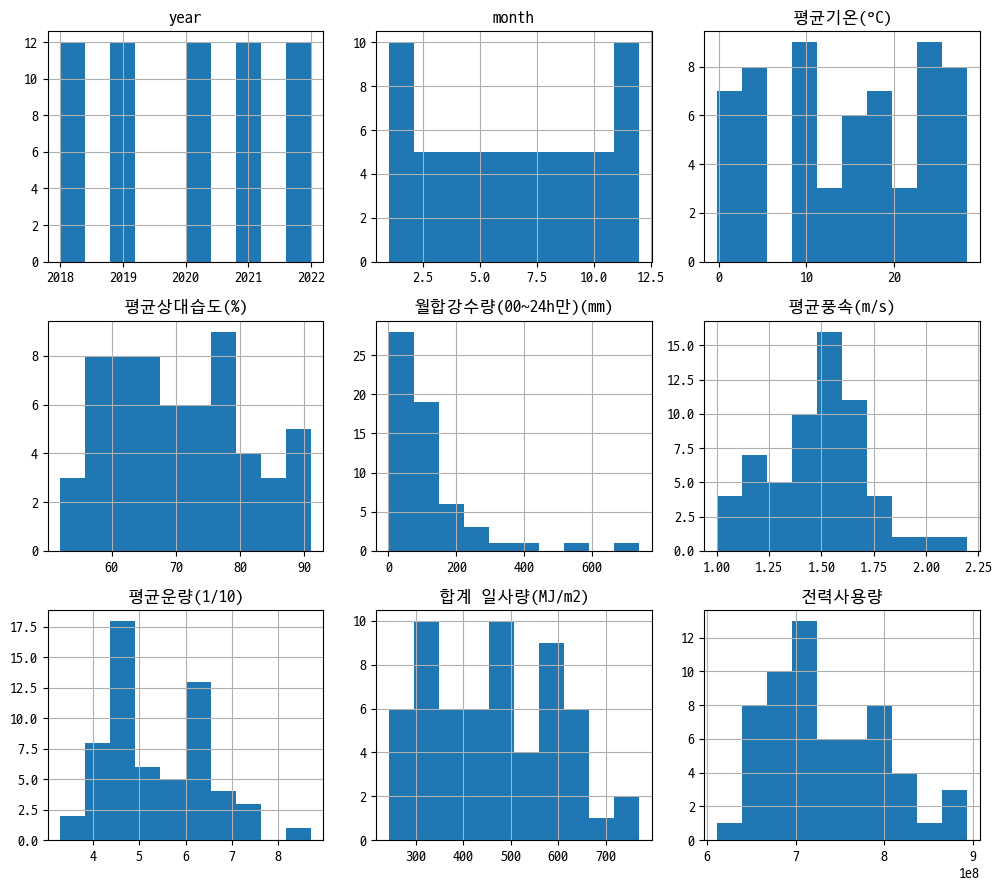

In [161]:
tmp_elc.hist(figsize=(10,9))
plt.tight_layout() # 그래프 간격 설정
plt.show()

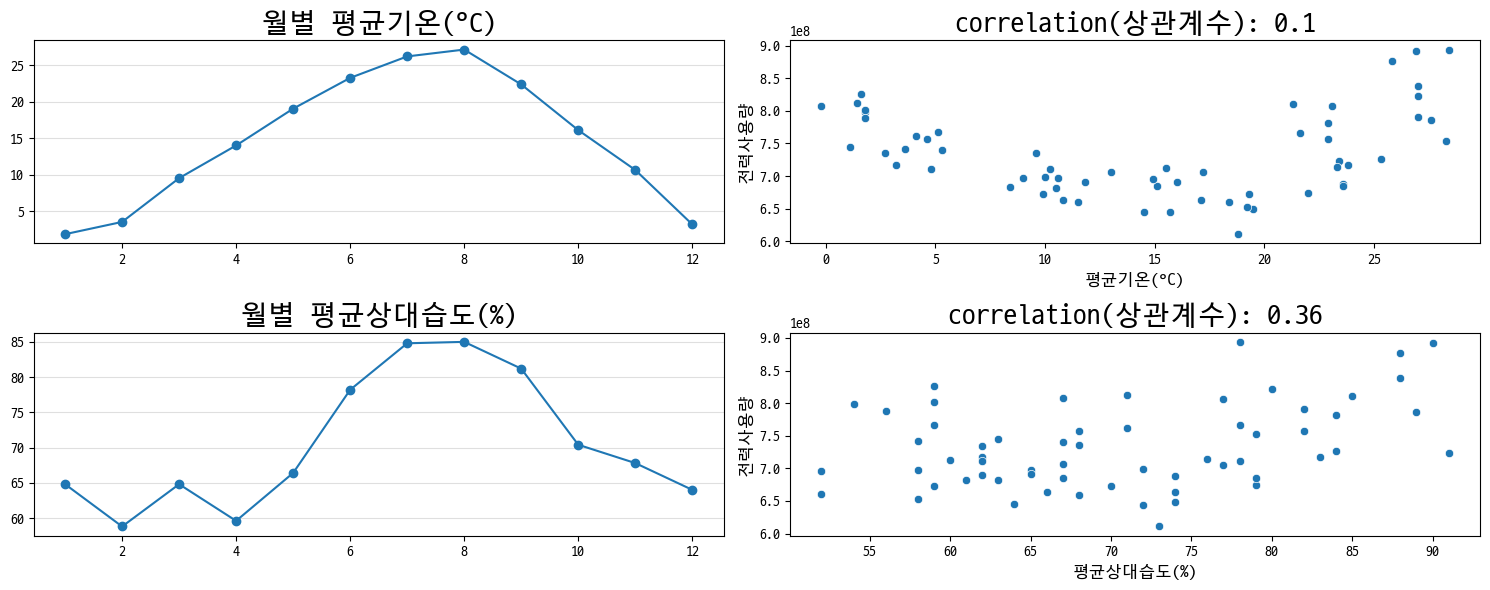

In [162]:
plt.figure(figsize=(15,6))
plt.subplot(2,2,1)
plt.plot(tmp_elc.groupby('month')['평균기온(°C)'].mean(),marker='o')
plt.grid(axis='y',linestyle='-', alpha=0.4)
plt.title('월별 평균기온(°C)', size=20)


plt.subplot(2,2,2)
correlation = tmp_elc['전력사용량'].corr(tmp_elc['평균기온(°C)'])
sns.scatterplot(x=tmp_elc['평균기온(°C)'], y=tmp_elc['전력사용량'])
plt.title('correlation(상관계수): '+str(np.round(correlation,2)), fontsize=20)
plt.xlabel("평균기온(°C)",fontsize=12)
plt.ylabel("전력사용량",fontsize=12)

plt.subplot(2,2,3)
plt.plot(tmp_elc.groupby('month')['평균상대습도(%)'].mean(),marker='o')
plt.grid(axis='y',linestyle='-', alpha=0.4)
plt.title('월별 평균상대습도(%)', size=20)


plt.subplot(2,2,4)
correlation = tmp_elc['전력사용량'].corr(tmp_elc['평균상대습도(%)'])
sns.scatterplot(x=tmp_elc['평균상대습도(%)'], y=tmp_elc['전력사용량'])
plt.title('correlation(상관계수): '+str(np.round(correlation,2)), fontsize=20)
plt.xlabel("평균상대습도(%)",fontsize=12)
plt.ylabel("전력사용량",fontsize=12)
plt.tight_layout()
plt.show()

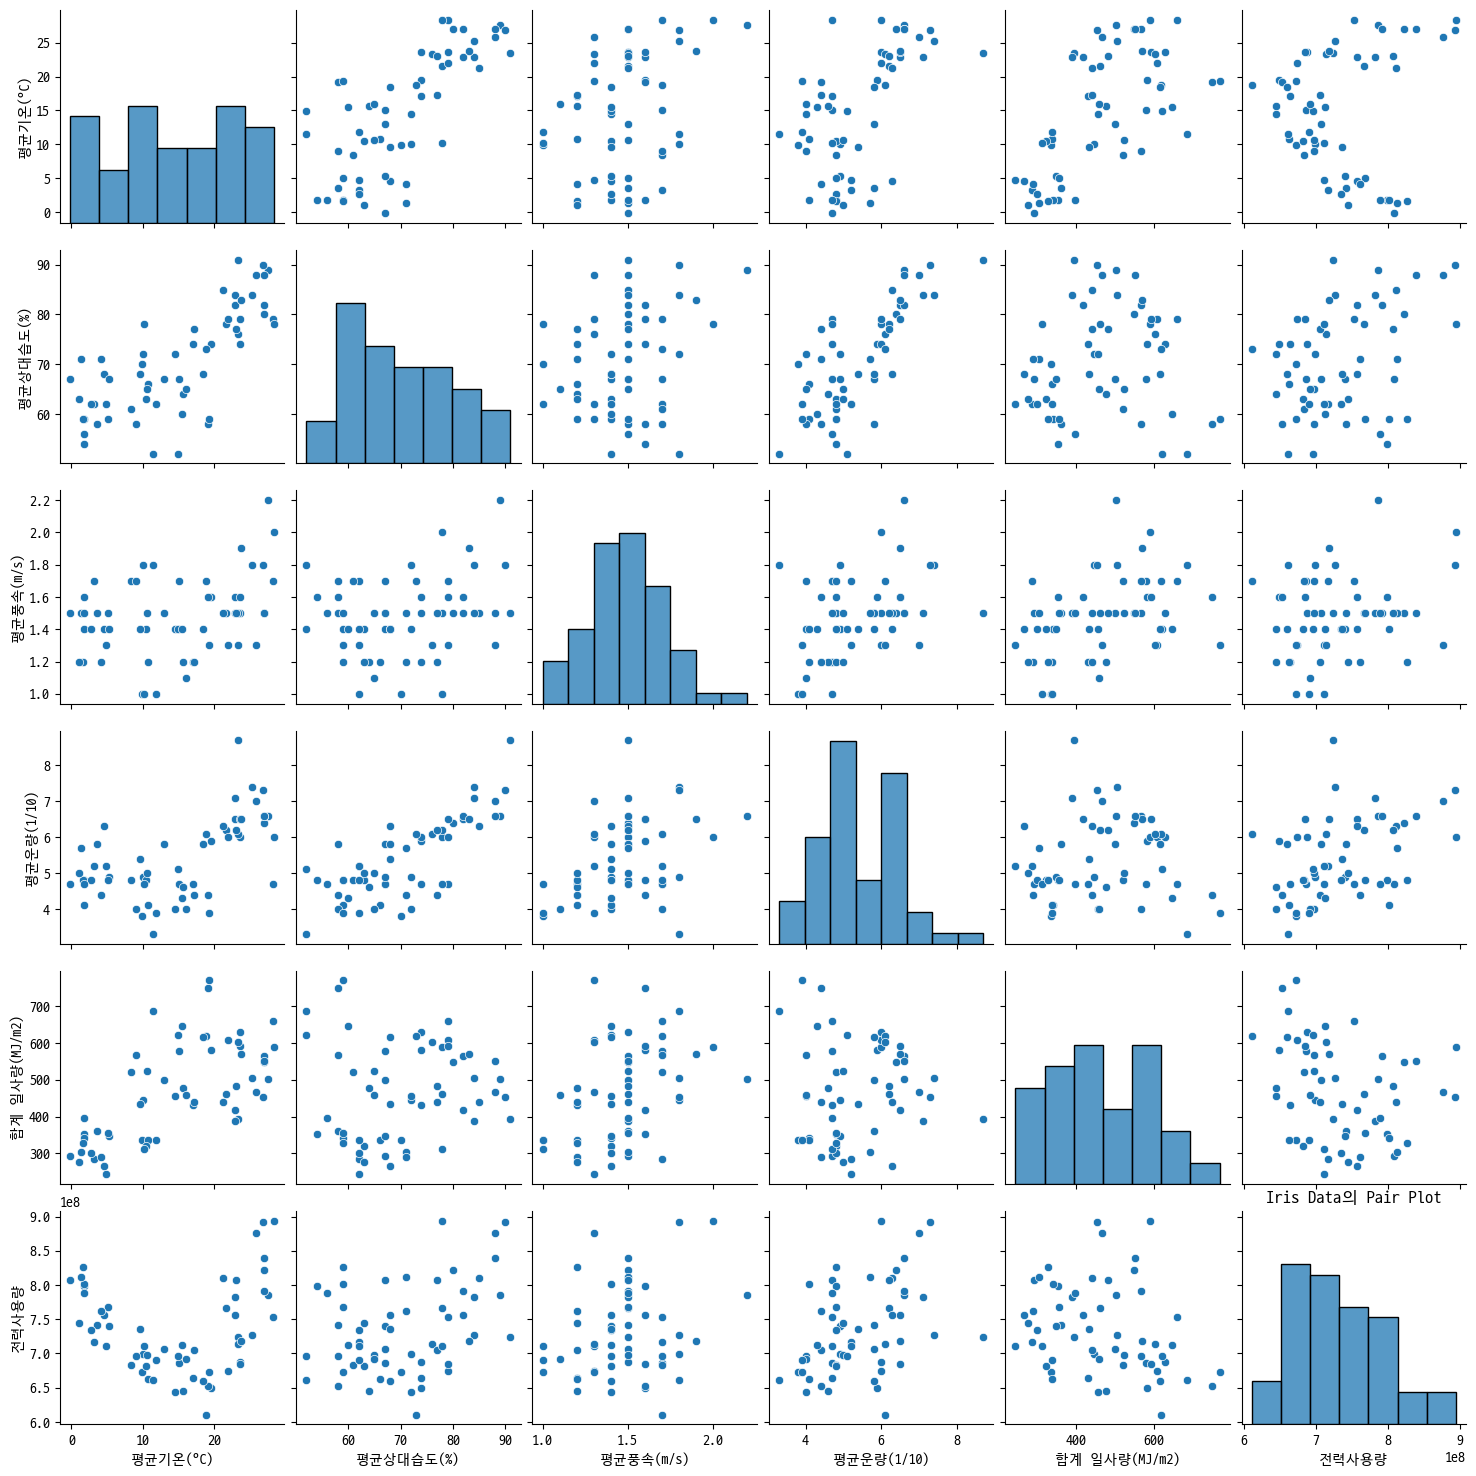

In [163]:
sns.pairplot(tmp_elc[['평균기온(°C)', '평균상대습도(%)',
       '평균풍속(m/s)', '평균운량(1/10)', '합계 일사량(MJ/m2)', '전력사용량']])
plt.title("Iris Data의 Pair Plot")
plt.show()


In [164]:
# 상관관계 도출
corr_matrix = tmp_elc.corr()
corr_matrix
# corr_matrix = corr_matrix.sort_values(by = 'OBP', axis = 0, ascending=False)
# corr_matrix = corr_matrix[corr_matrix.index]
# corr_matrix

,year,month,평균기온(°C),평균상대습도(%),월합강수량(00~24h만)(mm),평균풍속(m/s),평균운량(1/10),합계 일사량(MJ/m2),전력사용량
year,1.000000e+00,2.463352e-14,0.011563,0.008021,-0.101940,-0.284184,0.053348,0.000220,0.193831
month,2.463352e-14,1.000000e+00,0.267029,0.330708,0.110171,-0.309439,0.019848,-0.213216,-0.106893
평균기온(°C),1.156263e-02,2.670290e-01,1.000000,0.744309,0.603370,0.330281,0.576237,0.651962,0.097727
평균상대습도(%),8.020912e-03,3.307077e-01,0.744309,1.000000,0.666172,0.235997,0.763522,0.098129,0.357567
월합강수량(00~24h만)(mm),-1.019402e-01,1.101710e-01,0.603370,0.666172,1.000000,0.473290,0.627281,0.212266,0.235345
평균풍속(m/s),-2.841841e-01,-3.094391e-01,0.330281,0.235997,0.473290,1.000000,0.382195,0.375434,0.218270
평균운량(1/10),5.334849e-02,1.984832e-02,0.576237,0.763522,0.627281,0.382195,1.000000,0.066643,0.412896
합계 일사량(MJ/m2),2.202508e-04,-2.132165e-01,0.651962,0.098129,0.212266,0.375434,0.066643,1.000000,-0.272514
전력사용량,1.938308e-01,-1.068934e-01,0.097727,0.357567,0.235345,0.218270,0.412896,-0.272514,1.000000


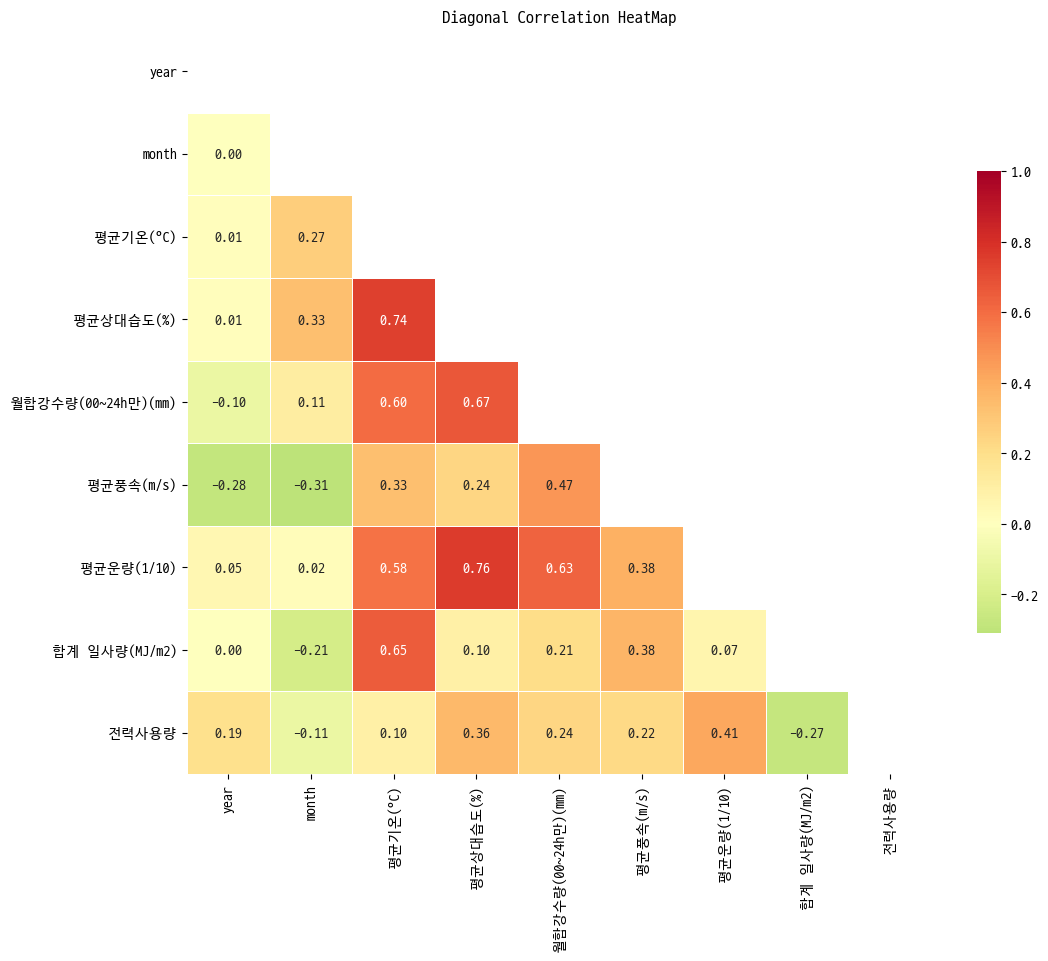

In [165]:
f, ax = plt.subplots(figsize=(12, 12))
corr = tmp_elc.select_dtypes(exclude=["object","bool"]).corr()

# 대각 행렬을 기준으로 한 쪽만 나타나게 설정해줍니다.
mask = np.zeros_like(corr_matrix, dtype='bool')
mask[np.triu_indices_from(mask)] = True

g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax= 1, mask=mask, 
center=0, annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Diagonal Correlation HeatMap")
plt.show()

In [166]:
tmp_elc.head()

,일시,year,month,평균기온(°C),평균상대습도(%),월합강수량(00~24h만)(mm),평균풍속(m/s),평균운량(1/10),합계 일사량(MJ/m2),전력사용량
0,2018-01-01,2018,1,-0.2,67,38.8,1.5,4.7,292.12,807535917
1,2018-02-01,2018,2,1.8,54,22.0,1.6,4.8,352.83,798506369
2,2018-03-01,2018,3,10.0,72,115.8,1.8,4.9,445.57,698659795
3,2018-04-01,2018,4,15.1,67,127.4,1.7,4.7,579.66,685492936
4,2018-05-01,2018,5,19.5,74,85.4,1.6,5.9,581.84,648944709


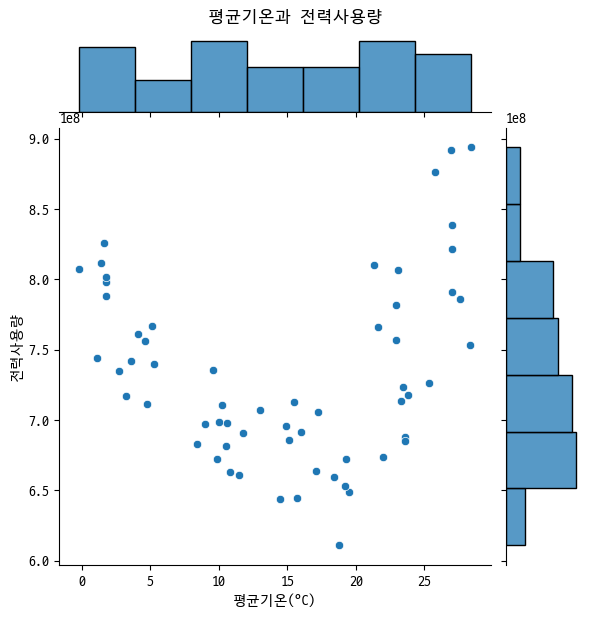

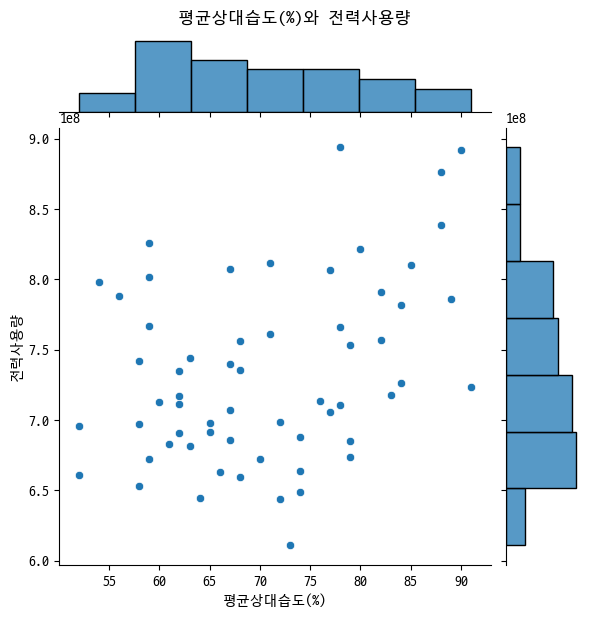

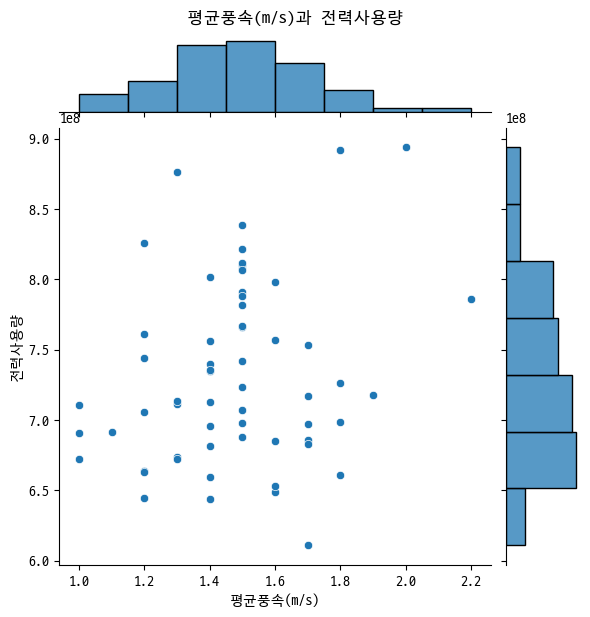

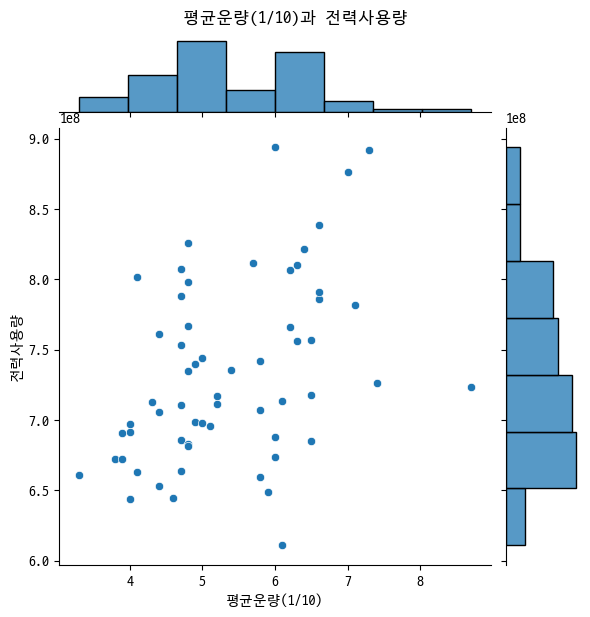

In [167]:

sns.jointplot(x="평균기온(°C)", y="전력사용량", data=tmp_elc)
plt.suptitle("평균기온과 전력사용량", y=1.02)

sns.jointplot(x="평균상대습도(%)", y="전력사용량", data=tmp_elc)
plt.suptitle("평균상대습도(%)와 전력사용량", y=1.02)


sns.jointplot(x="평균풍속(m/s)", y="전력사용량", data=tmp_elc)
plt.suptitle("평균풍속(m/s)과 전력사용량", y=1.02)

sns.jointplot(x="평균운량(1/10)", y="전력사용량", data=tmp_elc)
plt.suptitle("평균운량(1/10)과 전력사용량", y=1.02)
plt.show()

In [168]:
tmp_elc['일시'] = pd.to_datetime(tmp_elc['일시'],format='%Y-%m-%d')

In [169]:
tmp_elc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   일시                  60 non-null     datetime64[ns]
 1   year                60 non-null     int64         
 2   month               60 non-null     int64         
 3   평균기온(°C)            60 non-null     float64       
 4   평균상대습도(%)           60 non-null     int64         
 5   월합강수량(00~24h만)(mm)  60 non-null     float64       
 6   평균풍속(m/s)           60 non-null     float64       
 7   평균운량(1/10)          60 non-null     float64       
 8   합계 일사량(MJ/m2)       60 non-null     float64       
 9   전력사용량               60 non-null     int64         
dtypes: datetime64[ns](1), float64(5), int64(4)
memory usage: 7.2 KB


In [170]:
log_SalePrice = np.log1p(tmp_elc['전력사용량'])
sns.distplot(log_SalePrice)

<AxesSubplot:xlabel='전력사용량', ylabel='Density'>

In [171]:
tmp_elc_ohe = pd.get_dummies(tmp_elc)

In [172]:
log_SalePrice = np.log1p(tmp_elc_ohe['전력사용량'])

In [173]:
tmp_elc_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   일시                  60 non-null     datetime64[ns]
 1   year                60 non-null     int64         
 2   month               60 non-null     int64         
 3   평균기온(°C)            60 non-null     float64       
 4   평균상대습도(%)           60 non-null     int64         
 5   월합강수량(00~24h만)(mm)  60 non-null     float64       
 6   평균풍속(m/s)           60 non-null     float64       
 7   평균운량(1/10)          60 non-null     float64       
 8   합계 일사량(MJ/m2)       60 non-null     float64       
 9   전력사용량               60 non-null     int64         
dtypes: datetime64[ns](1), float64(5), int64(4)
memory usage: 7.2 KB


In [174]:
tmp_elc_ohe.set_index('일시',inplace=True)

In [175]:
tmp_elc_ohe

,year,month,평균기온(°C),평균상대습도(%),월합강수량(00~24h만)(mm),평균풍속(m/s),평균운량(1/10),합계 일사량(MJ/m2),전력사용량
일시,,,,,,,,,
2018-01-01,2018,1,-0.2,67,38.8,1.5,4.7,292.12,807535917
2018-02-01,2018,2,1.8,54,22.0,1.6,4.8,352.83,798506369
2018-03-01,2018,3,10.0,72,115.8,1.8,4.9,445.57,698659795
2018-04-01,2018,4,15.1,67,127.4,1.7,4.7,579.66,685492936
2018-05-01,2018,5,19.5,74,85.4,1.6,5.9,581.84,648944709
2018-06-01,2018,6,23.6,74,222.4,1.5,6.0,630.27,688052097
2018-07-01,2018,7,28.3,79,84.5,1.7,4.7,660.92,753263260
2018-08-01,2018,8,28.4,78,397.1,2.0,6.0,590.22,893914829
2018-09-01,2018,9,21.6,78,129.7,1.5,6.2,461.03,765903998


In [176]:
tmp_elc_ohe['전력사용량'].mean()

733308895.5333333

In [177]:
def get_rmse(model):
    from sklearn.metrics import mean_squared_error
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test,pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__,'로그 변환된 RMSE : ',rmse)
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [178]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split

In [179]:
y = tmp_elc_ohe['전력사용량']
X = tmp_elc_ohe.drop(columns=['전력사용량'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 156)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train,y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train,y_train)

models = [lr_reg,ridge_reg,lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE :  67751403.57107449
Ridge 로그 변환된 RMSE :  70129536.58151759
Lasso 로그 변환된 RMSE :  67751407.53752917


[67751403.57107449, 70129536.58151759, 67751407.53752917]

In [180]:
def get_top_bottom_coef(model,n=10):
    coef = pd.Series(model.coef_,index=X.columns)
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high,coef_low

In [181]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10), ncols = 3, nrows=1)
    fig.tight_layout()
    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 concat으로 결합
        coef_high,coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high,coef_low])
        # ax subplot에 barchar로 표현, 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
        axs[i_num].set_title(model.__class__.__name__,size=25)
        axs[i_num].tick_params(axis='y',direction='in',pad=-128)   # direction = 'in' 글자 들여쓰기
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values,y=coef_concat.index,ax=axs[i_num])


In [182]:
models = [lr_reg,ridge_reg,lasso_reg]
visualize_coefficient(models)

In [183]:
def get_avg_rmse_cv(models):
    from sklearn.model_selection import cross_val_score
    
    for model in models:
    # 분할하지 않고 전체 데이터로 cross_val_score() 수행, 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model,X,y,
                                             scoring='neg_mean_squared_error',cv=5))
        rmse_avg = np.mean(rmse_list)
        print(f'{model.__class__.__name__} rmse 값 리스트 : {rmse_list}')
        print(f'{model.__class__.__name__} rmse 값 평  균 : {rmse_avg}')

In [184]:
models = [lr_reg,ridge_reg,lasso_reg]
get_avg_rmse_cv(models)

# LinearRegression 로그 변환된 RMSE :  0.13189576579154072
# Ridge 로그 변환된 RMSE :  0.12750846334053154
# # Lasso 로그 변환된 RMSE :  0.17628250556471395

LinearRegression rmse 값 리스트 : [70895187.98111935 38777234.21749943 75172211.71945812 49215584.15382355
 50224381.50759719]
LinearRegression rmse 값 평  균 : 56856919.91589953
Ridge rmse 값 리스트 : [73241158.21773344 38908322.99812553 74540620.87017824 45098343.53632275
 52911008.09126549]
Ridge rmse 값 평  균 : 56939890.74272509
Lasso rmse 값 리스트 : [70895191.47677155 38777234.06871293 75172209.69610995 49215580.4769295
 50224383.05912922]
Lasso rmse 값 평  균 : 56856919.75553063


In [185]:
# 선형회귀 모델 객체 생성
from sklearn.preprocessing import PolynomialFeatures

X = tmp_elc_ohe[['평균기온(°C)','평균상대습도(%)']]
y = tmp_elc_ohe['전력사용량']
model = LinearRegression()
a = PolynomialFeatures()
X = a.fit_transform(X)

model.fit(X, y)
# 모델 예측
y_pred = model.predict(X)

# 모델 성능 측정 (R-squared)
print('R-squared: ', model.score(X, y))

# 모델 회귀 계수
print('Coefficients: ', model.coef_)

# 모델 절편
print('Intercept: ', model.intercept_)

R-squared:  0.6641031733857756
Coefficients:  [ 0.00000000e+00 -2.04132023e+07 -1.43421360e+07  6.49034484e+05
  1.12224609e+04  1.11929623e+05]
Intercept:  1273888171.5706432


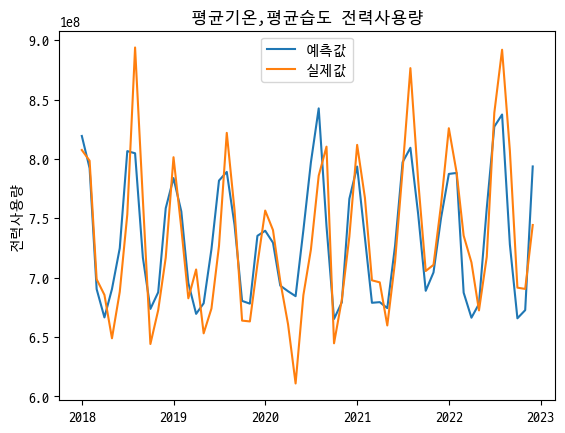

In [187]:
plt.plot(y.index,y_pred,label='예측값')
plt.plot(y,label='실제값')
plt.ylabel('전력사용량')
plt.title('평균기온,평균습도 전력사용량')
plt.legend(loc='upper center')
plt.show()

In [ ]:
tmp_elc_ohe.columns

Index(['year', 'month', '평균기온(°C)', '평균상대습도(%)', '월합강수량(00~24h만)(mm)',
       '평균풍속(m/s)', '평균운량(1/10)', '합계 일사량(MJ/m2)', '전력사용량'],
      dtype='object')

In [188]:
x = tmp_elc_ohe[['평균기온(°C)','평균상대습도(%)']]
y = tmp_elc_ohe['전력사용량']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

result = pd.DataFrame({'pred' : y_pred, 'real' : y_test})

result.head()

,pred,real
일시,,
2021-10-01,765903998,705603738
2018-11-01,698659795,672599955
2021-11-01,698659795,710813620
2019-03-01,716810703,682608470
2018-02-01,788536591,798506369


In [189]:
from sklearn.metrics import mean_absolute_error

print('MAE score:', mean_absolute_error(y_test, y_pred))
accuracy = model.score(x_train,y_train)
print('Accuracy:',accuracy)

MAE score: 30332256.111111112
Accuracy: 0.9761904761904762


In [190]:
result['ratio(%)'] = abs((result['pred'] - result['real']) / result['real']) * 100

result.head()

,pred,real,ratio(%)
일시,,,
2021-10-01,765903998,705603738,8.545910
2018-11-01,698659795,672599955,3.874493
2021-11-01,698659795,710813620,1.709847
2019-03-01,716810703,682608470,5.010520
2018-02-01,788536591,798506369,1.248553


In [191]:
import numpy as np

mean_ratio = np.mean(result['ratio(%)'])

print(mean_ratio)

4.203698831251224


In [192]:
num = [1, 10, 100, 200]

for i in num:
    model = RandomForestClassifier(n_estimators = i)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    percent = abs((y_pred - y_test) / y_test) * 100
    print(np.mean(percent))

6.230596205385762
5.943943713479488
5.554446313212397
6.035883535472895


In [193]:
import statsmodels.tsa.api as tsa

In [194]:
y = tmp_elc_ohe['전력사용량'].resample('1M').mean()

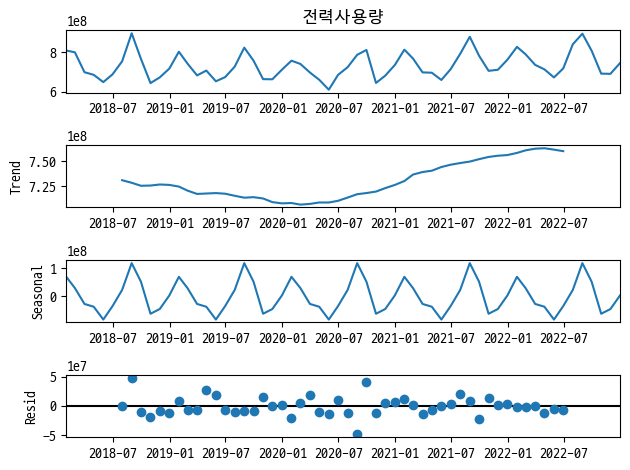

In [195]:
# 시계열 모델 생성
model_series = tsa.seasonal_decompose(y,model='additive')
# 모델 시각화
fig = model_series.plot()
plt.show()